# Fitting to ascospore data
Uses data from: *The teleomorph stage, Mycosphaerella graminicola, in  epidemics of septoria tritici blotch on winter wheat in  the UK, Hunter et al. 1999*

Also references *Wheat Growth Guide, AHDB, 2008*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
import pandas as pd

# For plotting
from Functions_plotting import plot_one_intervention, c1, c2, c3, c4, c5
from Functions_base import k, Temerge, T61,T87

# For ODEs
from Functions_base import ic_twofield, t_growing, beta_base, Temerge, gamma, g_1D, sigma, mu, v

# Fitting to the pseudothecia data

In [2]:
# This data comes from Hunter et al. 1999 paper. Uses 1993/94 data
discharged_data = np.array([4,6,36,4,10,30,18,50,20,24,28,30, 0, 0, 0, 0])
immature_data = np.array([20,8,8,38,8, 0,6,4, 0,0,0,0,0, 0,0,0])
mature_data = np.array([46,60,38,46,50,10,4,0,0,0,0,12,0,0,0,0])

print(discharged_data+immature_data+mature_data)

[70 74 82 88 68 40 28 54 20 24 28 42  0  0  0  0]


In [3]:
# Construct array of survey dates, day 0 is November 1st
dnov = np.array([2, 8, 15, 22, 29])
ddec = np.array([6, 13, 20]) + 30
djan = np.array([4, 10, 17, 24, 31]) + 31 + 30
dfeb = np.array([7,16,23]) + 31 + 31 + 30

dates = np.concatenate((dnov,ddec,djan,dfeb)) - 1

In [4]:
# Set initial condition with "all" (the maximum % of pseudothecia which are ever present) in the immature state
ic = [88,0,0]

# ODE system
def dPseudo(x,t,a,b,d):
    Imm, Mat, Dis = x
    dImm = - a*Imm
    dMat = a*Imm - b*Mat
    dDis = b*Mat - d*Dis
    return [dImm, dMat, dDis]

# Set generic initial parameters
a = 0.08
b = 0.04
d = 0.01
init_time = 5

# Fitting function
def fit_outbreak(paras):
    at,bt,dt,init_timet = paras
    
    # Return invalid value if input parameters are not in realistic range
    if at < 0 or bt < 0 or dt < 0 or init_timet < 0:
        return np.inf
    
    # Run outbreak under input parameters
    t = np.concatenate(([0],dates + init_timet))
    pop = odeint(y0 = ic, func = dPseudo, t = t,args = (at,bt,dt))
    
    imm = pop[:,0]
    mat = pop[:,1]
    dis = pop[:,2]

    # Computer error of model compared to data
    diff1 = np.linalg.norm((imm[1:] - immature_data))
    diff2 = np.linalg.norm((mat[1:] - mature_data))
    diff3 = np.linalg.norm((dis[1:] - discharged_data))
    
    diff = diff1 + diff2 + diff3
    return diff

# Minimise total error in model fit to data
pa = minimize(fit_outbreak, [a,b,d, init_time], method="Nelder-Mead")
a,b,d,init_time = pa["x"]
print("\na,b,d,init_time are \n" + str([a,b,d,init_time]))


a,b,d,init_time are 
[0.1019884909219626, 0.03798493455405656, 0.036623663437585996, 10.16195505132156]


In [5]:
# Run from our previous result and check that it we stay in the same minima
a,b,d,init_time = [0.1019884909219626, 0.03798493455405656, 0.036623663437585996, 10.16195505132156]

pa = minimize(fit_outbreak, [a,b,d, init_time], method="Nelder-Mead")
print(pa["x"])
a,b,d,init_time = pa["x"]

[ 0.10198873  0.03798505  0.03662366 10.16188304]


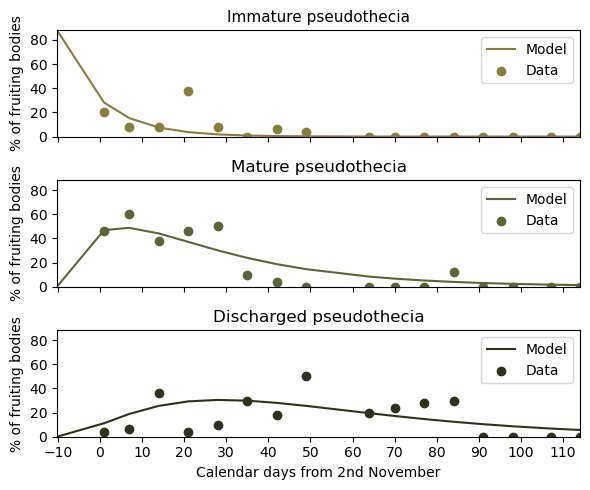

In [6]:
# 
t = np.concatenate(([0],dates + init_time))-init_time
pop = odeint(y0 = ic, func = dPseudo, t = t,args = (a,b,d))
imm = pop[:,0]
mat = pop[:,1]
dis = pop[:,2]

fig,ax = plt.subplots(3,figsize=(6,5))
ax1 = ax[0]
ax2 = ax[1]
ax3 = ax[2]

imm = ax1.plot(t, imm, c=c3,linestyle = '-',label = "Model")
mat = ax2.plot(t, mat, c=c4,linestyle = '-',label = "Model")
dis = ax3.plot(t, dis, c=c5,linestyle = '-',label = "Model")

immd = ax1.scatter(dates, immature_data, c=c3,linestyle='-',label = "Data")
matd = ax2.scatter(dates, mature_data, c=c4,linestyle='-',label = "Data")
disd = ax3.scatter(dates, discharged_data, c=c5,linestyle='-',label = "Data")

for ax in [ax1,ax2,ax3]:
    ax.set_yticks(ticks = np.arange(0,88,20))
    ax.set_ylim([0,88])
    ax.set_ylabel("% of fruiting bodies")
    ax.set_xticks(ticks = np.arange(-20,140,10))
    ax.set_xlim([-init_time,np.max(dates)])
    ax.legend(loc = "upper right")
    
ax1.tick_params(labelbottom=False)
ax2.tick_params(labelbottom=False)
ax3.set_xlabel("Calendar days from 2nd November")
ax1.set_title("Immature pseudothecia",fontsize=11)
ax2.set_title("Mature pseudothecia")
ax3.set_title("Discharged pseudothecia")
plt.tight_layout()
fig.savefig('Figures/Manuscript_final/fig_ascosporedata.pdf', dpi=400,bbox_inches='tight')

# Apply this fitting output to the IPM model

In [7]:
# Print fitted values - check that these align with those above!
print(a,b,d,init_time)

0.1019887271696656 0.03798504867676342 0.0366236620374572 10.161883036971702


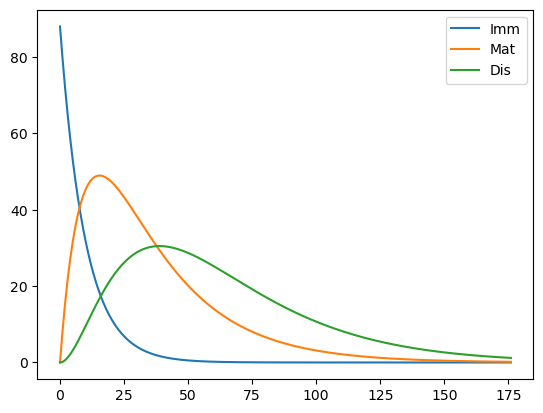

In [8]:
# Run pseudothecia simulation from our fitted initial time

# Time t = 0 in data is 2nd November.
# First day of this simulation is moved back by [init_time=10] days to 23rd October.
# Integrate up to first day (without late sowing) which is 18th April (see Hobbelen times)
# t should go up to the number of days between 23rd October and 18th April - that is 177 days

t = np.arange(0,177,1)
pop = odeint(y0 = ic, func = dPseudo, t = t, args = (a,b,d))
imm = pop[:,0]
mat = pop[:,1]
dis = pop[:,2]
plt.plot(t, imm, c='tab:blue',linestyle = '-', label = "Imm")
plt.plot(t, mat, c='tab:orange',linestyle = '-', label = "Mat")
plt.plot(t, dis, c='tab:green',linestyle = '-', label = "Dis")
plt.legend(loc = "upper right")
plt.show()

In [9]:
def get_ascospores(late_sow):
    # Read in Hobbelen time data, converts calendar days to degree days
    T = pd.read_excel("Hobbelen_times/T - winter wheat.xlsx", header=None,usecols=[0,1,2,3])
    
    # First leaf takes 150 degree days to develop (ref: Wheat Growth Guide 2008)
    def delay_first_leaf(n_days_late):
        i = 0
        cumsum = 0
        while i < T.shape[0] and cumsum < 150:
            cumsum += T[2][n_days_late+i]
            i += 1
            
        # Note that what it's returning is the end index which should be EXCLUDED.
        return i    

    # Find out when you start being exposed to ascospores if you plant "n" days late
    first_leaf = delay_first_leaf(late_sow) + late_sow

    # Compute maximum ascospore exposure (full integral; when leaves appear before October 23rd)
    asc_oct23 = np.trapz(mat)
    
    # Check if we've crossed the October 23rd threshold date (33 days after 20th September)
    if first_leaf <= 33:
        asc_delay = 1*asc_oct23
    else:
        asc_delay = np.trapz(mat[first_leaf-33:])    
        
    # Compute the proportion of ascospores you're exposed to given this late delay
    return asc_delay/asc_oct23

def get_growth_delay_CALENDAR_DAYS(late_sow):
    T = pd.read_excel("Hobbelen_times/T - winter wheat.xlsx", header=None,usecols=[0,1,2,3])
    
    # Find out how many degree-days of growth need to be made up later
    growth_delay_dd = get_growth_delay_DD(late_sow)
    
    # Find out how many calendar days it takes after Temerge
    idx_emerge = 210
    i = 0
    cumsum = 0
    while i < T.shape[0]-idx_emerge and cumsum < growth_delay_dd:
        cumsum += T[2][idx_emerge+i]
        i += 1
        
    # Note that what it's returning is the end index which should be EXCLUDED.
    return i

def get_growth_delay_DD(late_sow):
    T = pd.read_excel("Hobbelen_times/T - winter wheat.xlsx", header=None,usecols=[0,1,2,3])
    
    # Find out how many degree-days of growth need to be made up later
    growth_delay_dd = np.sum(T[2][:late_sow])
    
    return growth_delay_dd

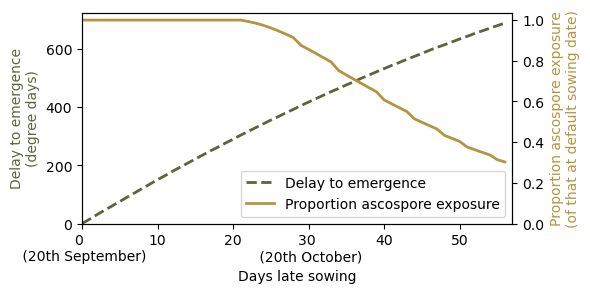

In [10]:
# Run for 56 days as the Wheat Growth Guide 2008 suggests the latest reasonable late sowing is mid-November, which is 56 days late (note we need 57 in length because of 0 days late being included)
N = 57
days_delay = np.zeros(N)
prop_asc = np.zeros(N)
dd_delay = np.zeros(N)
for i in range(N):

    # Compute calendar day delay, proportion of ascospore exposure, and degree-day delay
    days_delay[i] = get_growth_delay_CALENDAR_DAYS(i)
    prop_asc[i] = get_ascospores(i)
    dd_delay[i] = int(get_growth_delay_DD(i))

# Plot SI figure, prop_asc and dd_delay over the various delay options
fig,ax = plt.subplots(1,figsize=(6,3))
l1, = ax.plot(dd_delay,c=c4,label="Delay to emergence",linewidth=2,linestyle='--')
ax.set_ylabel("Delay to emergence\n(degree days)")
labels = [str(i) for i in range(0,N,10)]
labels[0] = "0 \n (20th September)"
labels[3] = "30 \n (20th October)"
ax.set_xticks(ticks = range(0,N,10),labels = labels)
ax.set_xlabel("Days late sowing")
ax.set_xlim([0,N])
ax.set_ylim(bottom = 0)

ax2 = ax.twinx()
l2, = ax2.plot(prop_asc,c=c2,label = "Proportion ascospore exposure",linewidth=2)
ax2.set_ylabel("Proportion ascospore exposure\n(of that at default sowing date)")
ax2.set_ylim(bottom = 0)

ax.legend([l1,l2], [l1.get_label(), l2.get_label()], loc = "lower right")
ax.yaxis.label.set_color(l1.get_color())
ax2.yaxis.label.set_color(l2.get_color())

plt.tight_layout()
fig.savefig('Figures/Manuscript_final/fig_sowing_delay_ascospores.pdf', dpi=400)

In [11]:
# Save outputs
np.save("dd_delay.npy",dd_delay)
np.save("prop_asc.npy",prop_asc)

In [12]:
# Print values we're interested in
print(prop_asc[0])
print(prop_asc[15])
print(prop_asc[30])
print(prop_asc[38])
print(prop_asc[56])

1.0
1.0
0.8559308747402736
0.66783096993903
0.3025114872131687


## Run key scenarios for paper

In [13]:
# Disease system
def dPop(ic,t,epi_severity,growth_delay):
    
    beta = beta_base*epi_severity
    
    S_M,E_M,I_M,R_M,D_M,P_M = ic[:6]
    S_N,E_N,I_N,R_N,D_N,P_N = ic[6:]
    
    A_M = S_M + E_M + I_M + R_M + D_M
    A_N = S_N + E_N + I_N + R_N + D_N
    
    # Residue management and late sowing fields
    if t > Temerge + growth_delay :
        FOL = gamma*E_M
            
        # Set transmission rate
        FOI = beta*(I_M + P_M)

        dS_M = g_1D(A_M,t) - sigma(t)*S_M - (S_M/A_M)*FOI
        dE_M = (S_M/A_M)*FOI - sigma(t)*E_M - FOL
        dI_M = FOL - mu*I_M
        dR_M = sigma(t)*(S_M+E_M)
        dD_M = mu*I_M
        dP_M = -v*P_M
        
    else:
        dS_M = 0
        dE_M = 0
        dI_M = 0
        dR_M = 0
        dD_M = 0
        dP_M = 0

    # Uncontrolled fields
    if t > Temerge:
        
        # Set uncontrolled FOI
        FOI = beta*(I_N + P_N)
        
        dS_N = g_1D(A_N,t) - sigma(t)*S_N - (S_N/A_N)*FOI
        dE_N = (S_N/A_N)*FOI - sigma(t)*E_N - gamma*E_N
        dI_N = gamma*E_N - mu*I_N
        dR_N = sigma(t)*(S_N+E_N)
        dD_N = mu*I_N
        dP_N = -v*P_N
        
    else:
        dS_N = 0
        dE_N = 0
        dI_N = 0
        dR_N = 0
        dD_N = 0
        dP_N = 0

    return [dS_M,dE_M,dI_M,dR_M,dD_M,dP_M, dS_N,dE_N,dI_N,dR_N,dD_N,dP_N]

In [14]:
# Standard delay
sow_delay = 30
growth_delay = dd_delay[sow_delay]
prop_ascospores = prop_asc[sow_delay]
ic = 1*ic_twofield
ic[5] = prop_ascospores*ic[5]
pop2 = odeint(func = dPop, y0 = ic, t = t_growing, args = (1,growth_delay))

# No control is minimum delay
pop1 = pop2[:,6:]

# Maximum delay
sow_delay = 56
growth_delay = dd_delay[sow_delay]
prop_ascospores = prop_asc[sow_delay]
ic = 1*ic_twofield
ic[5] = prop_ascospores*ic[5]
pop3 = odeint(func = dPop, y0 = ic, t = t_growing, args = (1,growth_delay))

In [15]:
# Find the "best yield" scenario
from Functions_analysis import Y
best_Y = -np.inf
best_i = -np.inf

for i in range(N):
    growth_delay = dd_delay[i]
    prop_ascospores = prop_asc[i]
    ic = 1*ic_twofield
    ic[5] = prop_ascospores*ic[5]
    this_pop = odeint(func = dPop, y0 = ic, t = t_growing, args = (1,growth_delay))
    this_Y = Y(this_pop[:,:6])
    
    if this_Y > best_Y:
        best_Y = 1*this_Y
        best_i = 1*i
        
print("Best i is " + str(best_i))

# Now best has been found, run this scenario
sow_delay = best_i
growth_delay = dd_delay[sow_delay]
prop_ascospores = prop_asc[sow_delay]
ic = 1*ic_twofield
ic[5] = prop_ascospores*ic[5]

pop4 = odeint(func = dPop, y0 = ic, t = t_growing, args = (1,growth_delay))

Best i is 38


Yields
[0.7172895172657651, 0.9568669764410591, 0.969568094600089, 0.8836329953868599]
Peak percent infection
[0.22317163977134766, 0.046183224986547394, 0.02297778485459403, 0.003999637964575926]
Peak infection time
[2781, 2948, 2960, 2970]


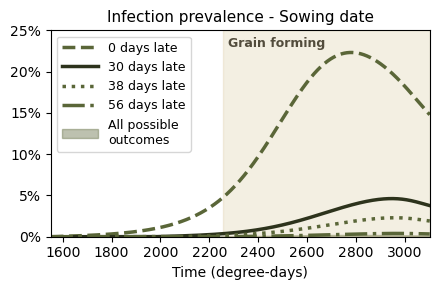

In [16]:
# Run imported plotting function
fig,ax = plot_one_intervention([pop1,pop2[:,:6],pop4[:,:6],pop3[:,:6]],["0 days late", "30 days late", "38 days late", "56 days late"],"Sowing date",2)
plt.tight_layout()
# Save figure
fig.savefig('Figures/Manuscript_final/fig_1control_latesowing.pdf', dpi=400)